<a href="https://colab.research.google.com/github/tahminehladi/unsupervised_learning_customer_segmentation/blob/main/Customer_segmentation_unsupervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/Mydrive')

Mounted at /content/Mydrive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics

import warnings
import sys
if not sys.warnoptions:
  warnings.simplefilter('ignore')
np.random.seed(42)

In [21]:
df=pd.read_csv('/content/Mydrive/MyDrive/TensorFlow_data/marketing_campaign.csv',
               sep='\t') # file is separated by tabs rather than commas (the default delimiter)

print(len(df))
df.head()

2240


ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [23]:
# remove missing values
df=df.dropna()
len(df)

2216

In [6]:
df.Dt_Customer.head()

0    04-09-2012
1    08-03-2014
2    21-08-2013
3    10-02-2014
4    19-01-2014
Name: Dt_Customer, dtype: object

In [24]:
df['Dt_Customer']=pd.to_datetime(df['Dt_Customer'], dayfirst=True)
df.Dt_Customer.head().sort_values()

0   2012-09-04
2   2013-08-21
4   2014-01-19
3   2014-02-10
1   2014-03-08
Name: Dt_Customer, dtype: datetime64[ns]

In [25]:
df.Dt_Customer.max(), df.Dt_Customer.min()

(Timestamp('2014-06-29 00:00:00'), Timestamp('2012-07-30 00:00:00'))

In [26]:
dates=[]
for i in df['Dt_Customer']:
  i=i.date()
  dates.append(i)

# dates of the newest and oldest recorded customer
print('The newest customer enrolment date:', max(dates))
print('The oldest customer enrolment date:', min(dates))

The newest customer enrolment date: 2014-06-29
The oldest customer enrolment date: 2012-07-30


In [27]:
days=[]
d1=max(dates) # taking it to be the newest customer
for i in dates:
  delta=d1-i
  days.append(delta)
df['Customer_for']=days
df['Customer_for'].head()

0   663 days
1   113 days
2   312 days
3   139 days
4   161 days
Name: Customer_for, dtype: timedelta64[ns]

In [29]:
df['Customer_for']= pd.to_numeric(df['Customer_for'])
df['Customer_for'].head()

0    57283200000000000
1     9763200000000000
2    26956800000000000
3    12009600000000000
4    13910400000000000
Name: Customer_for, dtype: int64

In [30]:
df['Marital_Status'].value_counts()

Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

In [14]:
df.Education.value_counts()

Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64

In [32]:
# feature Engineering

# age of customer
df['age']=2024-df['Year_Birth']

# total spending on various items
df['spent']=df['MntWines'] + df['MntFruits'] +df['MntFishProducts']+ df['MntGoldProds'] +df['MntSweetProducts']+ df['MntMeatProducts']

# divding Marital_status into two groups, partner or alone
df['living_with']=df['Marital_Status'].replace({'Married': 'partner', 'Together': 'partner',
                                                'Single': 'Alone', 'Divorced': 'Alone',
                                                'Widow': 'Alone', 'Absurd': 'Alone',
                                                'YOLO': 'Alone'})

# Total childeren
df['children']= df['Kidhome']+ df['Teenhome']


df['family_size']=df['living_with'].replace({'Alone': 1, 'partner': 2}) + df['children']

df['is_parent']= np.where(df.children >0, 1,0)
# segmenting educaton levels in three groups
df['education']= df['Education'].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate",
                                          "Graduation":"Graduate", "Master":"Postgraduate",
                                          "PhD":"Postgraduate"})

df=df.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat",
                      "MntFishProducts":"Fish",
                      "MntSweetProducts":"Sweets","MntGoldProds":"Gold"})


# drooping unneed columns
to_drop = ["Marital_Status", "Education","Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
df=df.drop(to_drop, axis=1)


<ipython-input-32-e3489d104f84>:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['family_size']=df['living_with'].replace({'Alone': 1, 'partner': 2}) + df['children']


In [16]:
df.head()

Income  Kidhome  Teenhome  Recency  Wines  Fruits  Meat  Fish  Sweets  \
0  58138.0        0         0       58    635      88   546   172      88   
1  46344.0        1         1       38     11       1     6     2       1   
2  71613.0        0         0       26    426      49   127   111      21   
3  26646.0        1         0       26     11       4    20    10       3   
4  58293.0        1         0       94    173      43   118    46      27   

   Gold  ...  AcceptedCmp1  AcceptedCmp2  Complain  Response  Customer_for  \
0    88  ...             0             0         0         1      663 days   
1     6  ...             0             0         0         0      113 days   
2    42  ...             0             0         0         0      312 days   
3     5  ...             0             0         0         0      139 days   
4    15  ...             0             0         0         0      161 days   

   age  spent  living_with  children     education  
0   67   1617        Alone         0      Graduate  
1   70     27        Alone         2      Graduate  
2   59    776      partner         0      Graduate  
3   40     53      partner         1      Graduate  
4   43    422      partner         1  Postgraduate  

[5 rows x 28 columns]

In [33]:
df.describe()

Income      Kidhome     Teenhome      Recency        Wines  \
count    2216.000000  2216.000000  2216.000000  2216.000000  2216.000000   
mean    52247.251354     0.441787     0.505415    49.012635   305.091606   
std     25173.076661     0.536896     0.544181    28.948352   337.327920   
min      1730.000000     0.000000     0.000000     0.000000     0.000000   
25%     35303.000000     0.000000     0.000000    24.000000    24.000000   
50%     51381.500000     0.000000     0.000000    49.000000   174.500000   
75%     68522.000000     1.000000     1.000000    74.000000   505.000000   
max    666666.000000     2.000000     2.000000    99.000000  1493.000000   

            Fruits         Meat         Fish       Sweets         Gold  ...  \
count  2216.000000  2216.000000  2216.000000  2216.000000  2216.000000  ...   
mean     26.356047   166.995939    37.637635    27.028881    43.965253  ...   
std      39.793917   224.283273    54.752082    41.072046    51.815414  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       2.000000    16.000000     3.000000     1.000000     9.000000  ...   
50%       8.000000    68.000000    12.000000     8.000000    24.500000  ...   
75%      33.000000   232.250000    50.000000    33.000000    56.000000  ...   
max     199.000000  1725.000000   259.000000   262.000000   321.000000  ...   

       AcceptedCmp1  AcceptedCmp2     Complain     Response  Customer_for  \
count   2216.000000   2216.000000  2216.000000  2216.000000  2.216000e+03   
mean       0.064079      0.013538     0.009477     0.150271  3.054423e+16   
std        0.244950      0.115588     0.096907     0.357417  1.749036e+16   
min        0.000000      0.000000     0.000000     0.000000  0.000000e+00   
25%        0.000000      0.000000     0.000000     0.000000  1.555200e+16   
50%        0.000000      0.000000     0.000000     0.000000  3.071520e+16   
75%        0.000000      0.000000     0.000000     0.000000  4.570560e+16   
max        1.000000      1.000000     1.000000     1.000000  6.039360e+16   

               age        spent     children  family_size    is_parent  
count  2216.000000  2216.000000  2216.000000  2216.000000  2216.000000  
mean     55.179603   607.075361     0.947202     2.592509     0.714350  
std      11.985554   602.900476     0.749062     0.905722     0.451825  
min      28.000000     5.000000     0.000000     1.000000     0.000000  
25%      47.000000    69.000000     0.000000     2.000000     0.000000  
50%      54.000000   396.500000     1.000000     3.000000     1.000000  
75%      65.000000  1048.000000     1.000000     3.000000     1.000000  
max     131.000000  2525.000000     3.000000     5.000000     1.000000  

[8 rows x 28 columns]

<Figure size 800x550 with 0 Axes>

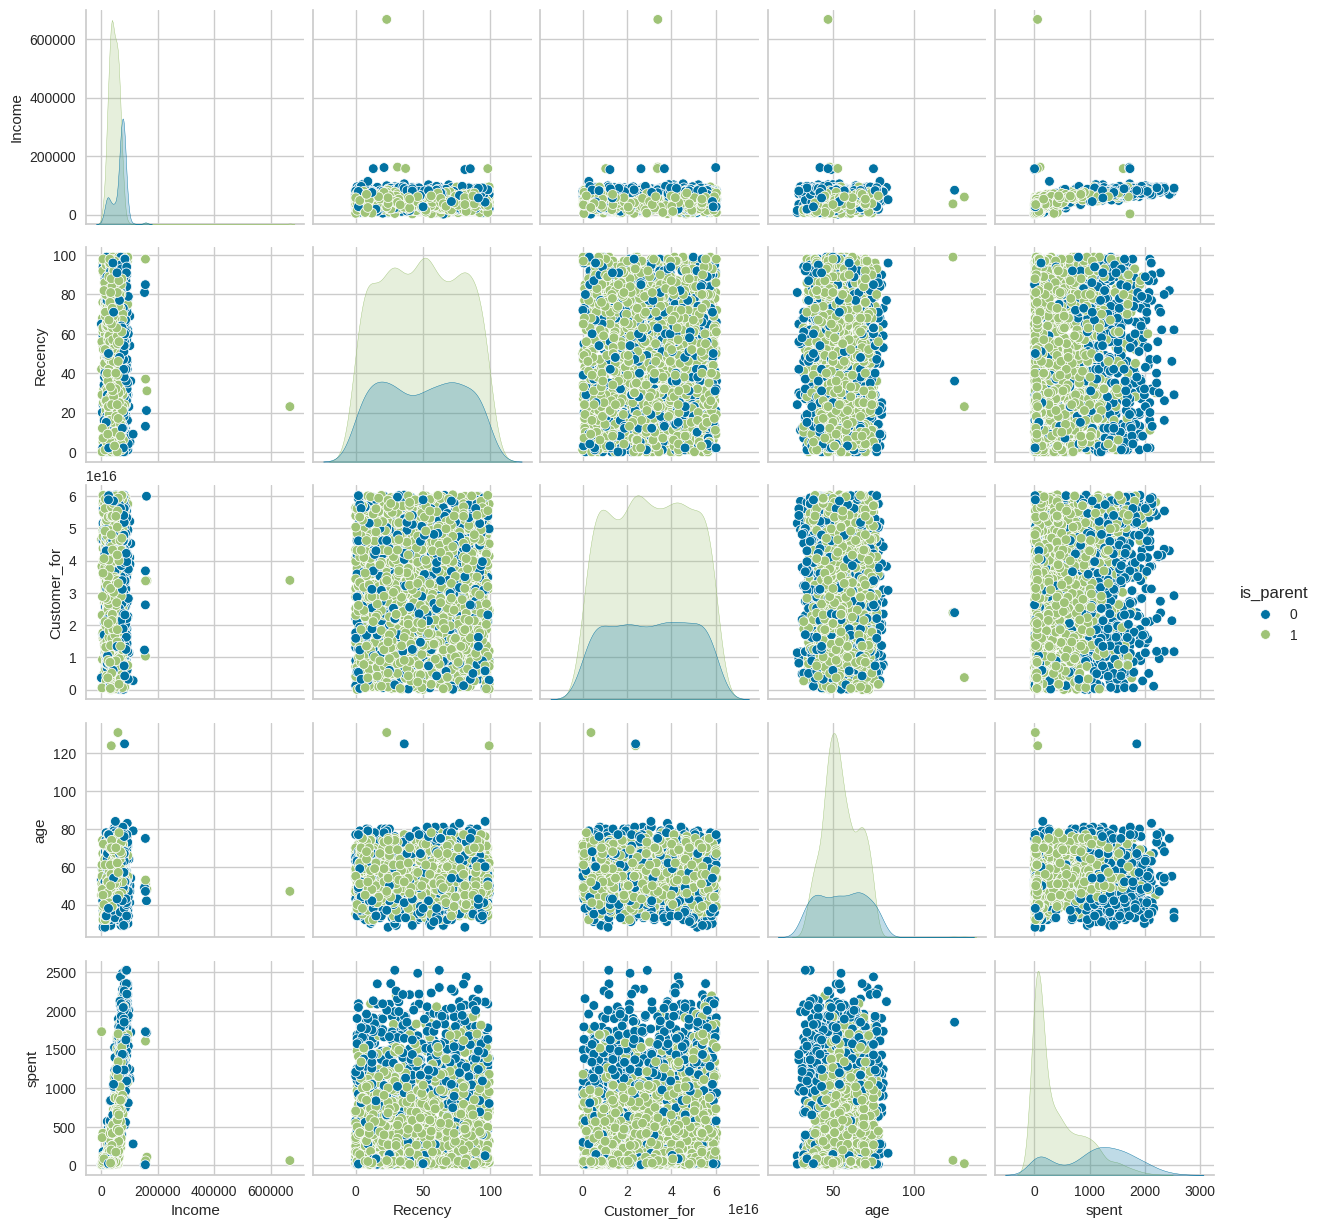

In [34]:
#plotting some features
to_plot= ['Income', 'Recency', 'Customer_for', 'age', 'spent', 'is_parent']
plt.figure()
sns.pairplot(df[to_plot], hue= 'is_parent')
plt.show()

In [35]:
# there are some outliers in the income and age features, so I will drop them

df=df[(df['age'] <90)]
df=df[(df['Income']< 600000)]
len(df)

2212

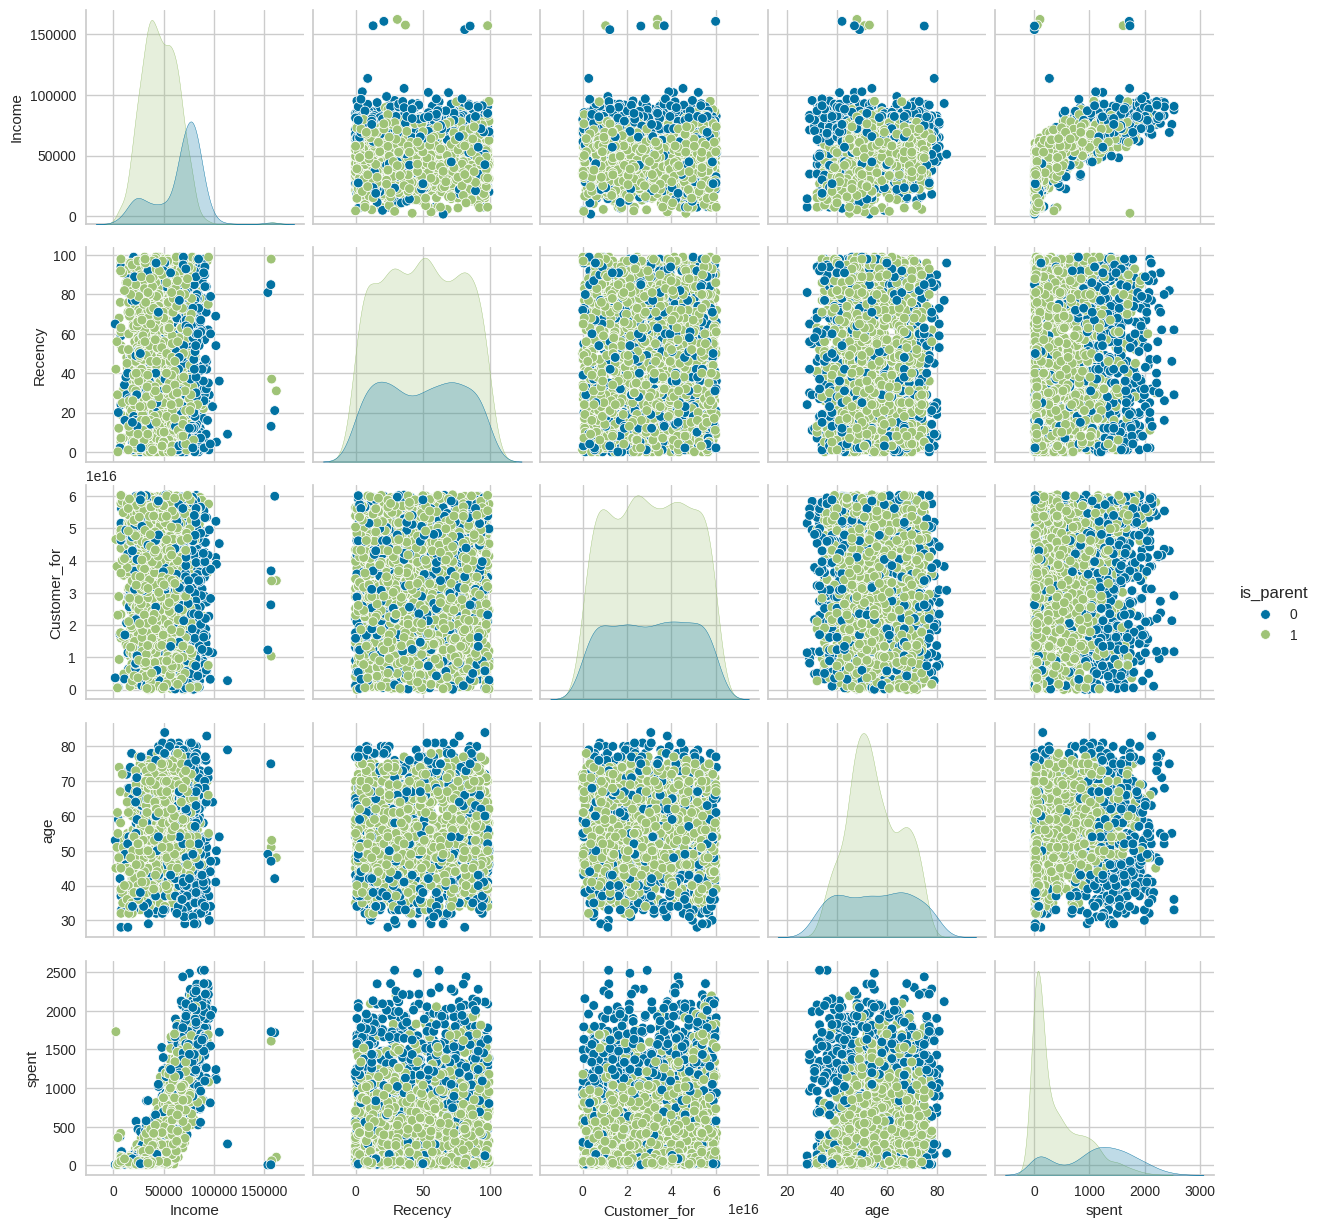

In [36]:
# plots after removing outliers
sns.pairplot(df[to_plot], hue= 'is_parent')
plt.show()

<Axes: >

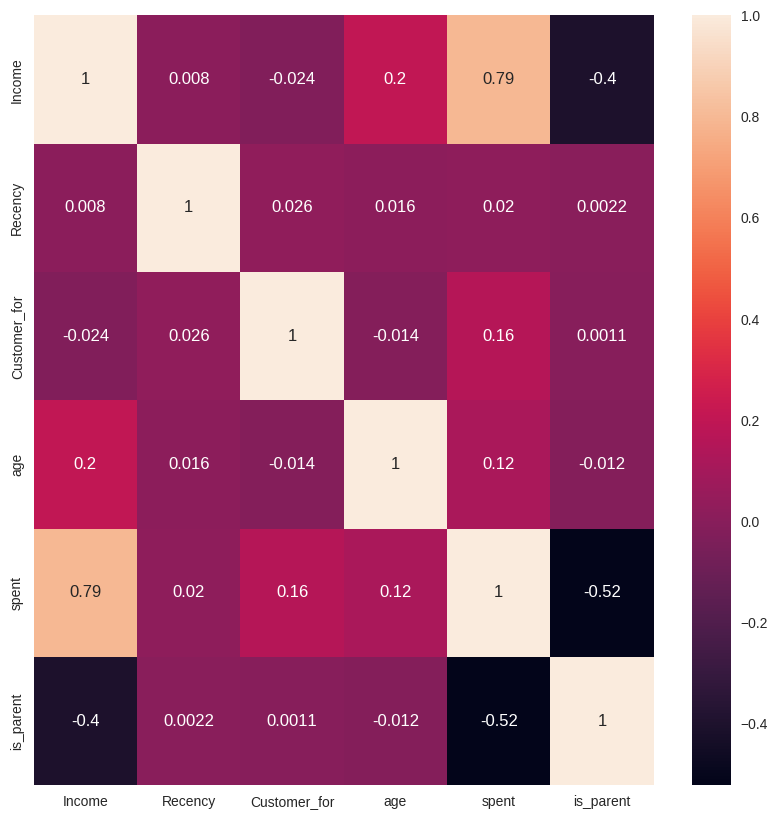

In [39]:
# correlation matrix

corrmax=df[to_plot].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmax, annot=True)

In [42]:
cat_features=[label for label, content in df.items() if not pd.api.types.is_numeric_dtype(content)]
cat_features

['living_with', 'education']

In [43]:
# convert stirng to numeric
labelencoder=LabelEncoder()
for i in cat_features:
  df[i]=df[[i]].apply(labelencoder.fit_transform)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2212 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Income               2212 non-null   float64
 1   Kidhome              2212 non-null   int64  
 2   Teenhome             2212 non-null   int64  
 3   Recency              2212 non-null   int64  
 4   Wines                2212 non-null   int64  
 5   Fruits               2212 non-null   int64  
 6   Meat                 2212 non-null   int64  
 7   Fish                 2212 non-null   int64  
 8   Sweets               2212 non-null   int64  
 9   Gold                 2212 non-null   int64  
 10  NumDealsPurchases    2212 non-null   int64  
 11  NumWebPurchases      2212 non-null   int64  
 12  NumCatalogPurchases  2212 non-null   int64  
 13  NumStorePurchases    2212 non-null   int64  
 14  NumWebVisitsMonth    2212 non-null   int64  
 15  AcceptedCmp3         2212 non-null   int64 

In [45]:
ds=df.copy()

In [51]:
# removing unneeded columns/features
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
            'AcceptedCmp2', 'Complain', 'Response']
ds=ds.drop(cols_del, axis=1)

In [52]:
ds.head()

Income  Kidhome  Teenhome  Recency  Wines  Fruits  Meat  Fish  Sweets  \
0  58138.0        0         0       58    635      88   546   172      88   
1  46344.0        1         1       38     11       1     6     2       1   
2  71613.0        0         0       26    426      49   127   111      21   
3  26646.0        1         0       26     11       4    20    10       3   
4  58293.0        1         0       94    173      43   118    46      27   

   Gold  ...  NumStorePurchases  NumWebVisitsMonth       Customer_for  age  \
0    88  ...                  4                  7  57283200000000000   67   
1     6  ...                  2                  5   9763200000000000   70   
2    42  ...                 10                  4  26956800000000000   59   
3     5  ...                  4                  6  12009600000000000   40   
4    15  ...                  6                  5  13910400000000000   43   

   spent  living_with  children  family_size  is_parent  education  
0   1617            0         0            1          0          0  
1     27            0         2            3          1          0  
2    776            1         0            2          0          0  
3     53            1         1            3          1          0  
4    422            1         1            3          1          1  

[5 rows x 23 columns]

In [53]:
# scaling

scaler= StandardScaler()
scaler.fit(ds)
scaler_ds=pd.DataFrame(scaler.transform(ds), columns=ds.columns)
scaler_ds.head()

Income   Kidhome  Teenhome   Recency     Wines    Fruits      Meat  \
0  0.287105 -0.822754 -0.929699  0.310353  0.977660  1.552041  1.690293   
1 -0.260882  1.040021  0.908097 -0.380813 -0.872618 -0.637461 -0.718230   
2  0.913196 -0.822754 -0.929699 -0.795514  0.357935  0.570540 -0.178542   
3 -1.176114  1.040021 -0.929699 -0.795514 -0.872618 -0.561961 -0.655787   
4  0.294307  1.040021 -0.929699  1.554453 -0.392257  0.419540 -0.218684   

       Fish    Sweets      Gold  ...  NumStorePurchases  NumWebVisitsMonth  \
0  2.453472  1.483713  0.852576  ...          -0.555814           0.692181   
1 -0.651004 -0.634019 -0.733642  ...          -1.171160          -0.132545   
2  1.339513 -0.147184 -0.037254  ...           1.290224          -0.544908   
3 -0.504911 -0.585335 -0.752987  ...          -0.555814           0.279818   
4  0.152508 -0.001133 -0.559545  ...           0.059532          -0.132545   

   Customer_for       age     spent  living_with  children  family_size  \
0      1.527721  1.018352  1.676245    -1.349603 -1.264598    -1.758359   
1     -1.189011  1.274785 -0.963297    -1.349603  1.404572     0.449070   
2     -0.206048  0.334530  0.280110     0.740959 -1.264598    -0.654644   
3     -1.060584 -1.289547 -0.920135     0.740959  0.069987     0.449070   
4     -0.951915 -1.033114 -0.307562     0.740959  0.069987     0.449070   

   is_parent  education  
0  -1.581139  -0.893586  
1   0.632456  -0.893586  
2  -1.581139  -0.893586  
3   0.632456  -0.893586  
4   0.632456   0.571657  

[5 rows x 23 columns]

In this problem, there are many factors on the basis of which the final classification will be done. These factors are basically attributes or features. The higher the number of features, the harder it is to work with it. Many of these features are correlated, and hence redundant. This is why I will be performing dimensionality reduction on the selected features before putting them through a classifier.
Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables.


For this project, I will be reducing the dimensions to 3.

In [55]:
# PCA to reduce dimentions
pca=PCA(n_components=3)
pca.fit(scaler_ds)
pca_ds=pd.DataFrame(pca.transform(scaler_ds), columns=(['col1', 'col2', 'col3']))
pca_ds.describe().T


count          mean       std       min       25%       50%       75%  \
col1  2212.0  1.927331e-17  2.878602 -5.978124 -2.539470 -0.781595  2.386380   
col2  2212.0  0.000000e+00  1.709469 -4.194757 -1.323929 -0.173721  1.234851   
col3  2212.0 -1.525804e-17  1.231687 -3.625248 -0.853713 -0.050842  0.863974   

           max  
col1  7.452915  
col2  6.168189  
col3  6.750458

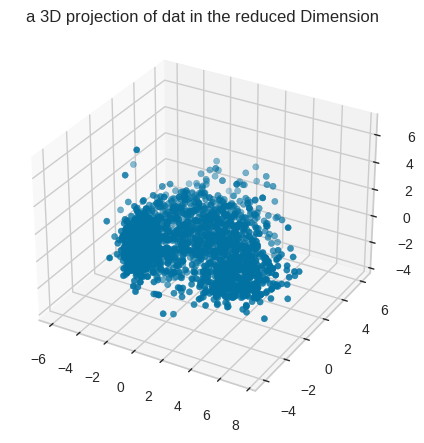

In [60]:
# a 3D projection of Data in the reduced dimension

X=pca_ds['col1']
y=pca_ds['col2']
z=pca_ds['col3']

# to plot
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111, projection='3d')
ax.scatter(X, y, z)
ax.set_title('a 3D projection of dat in the reduced Dimension')
plt.show()

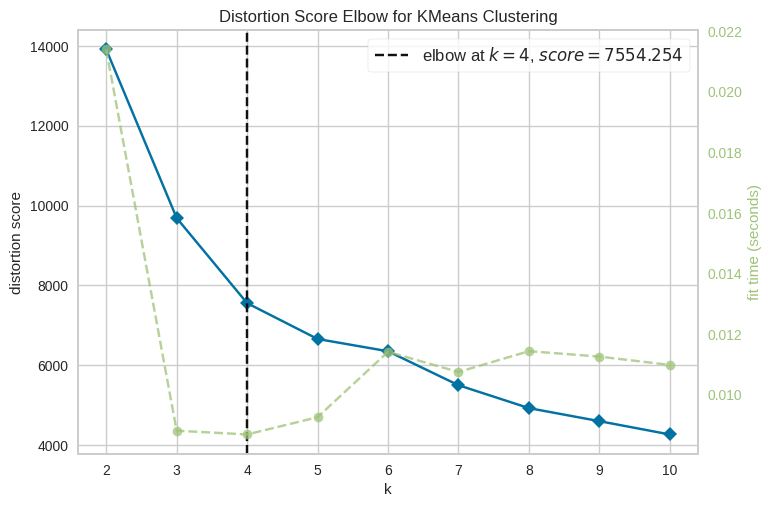

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [62]:
# Clustering

# elbow method to find numbers of clusters to make
elbow_m=KElbowVisualizer(KMeans(), k=10)
elbow_m.fit(pca_ds)
elbow_m.show()

The above cell indicates that four will be an optimal number of clusters for this data. Next, we will be fitting the Agglomerative Clustering Model to get the final clusters.

In [63]:
# initiating the Agglomerative Clustering model

AC= AgglomerativeClustering(n_clusters=4)
yhat_AC=AC.fit_predict(pca_ds)
pca_ds['Clusters']=yhat_AC
df['clusters']=yhat_AC

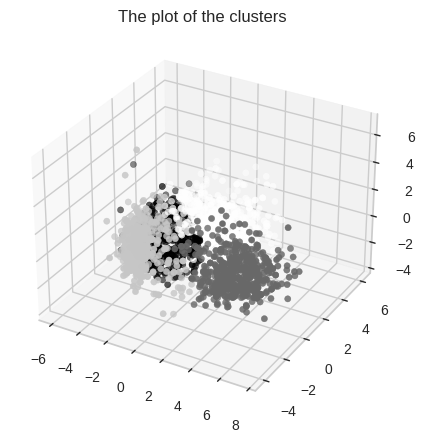

In [70]:
# plotting the clusters
fig=plt.figure(figsize=(10,5))
ax=plt.subplot(111, projection='3d')
ax.scatter(X, y, z, c=pca_ds['Clusters'])
ax.set_title('The plot of the clusters')
plt.show()

evaluate the clusters by doing EDA

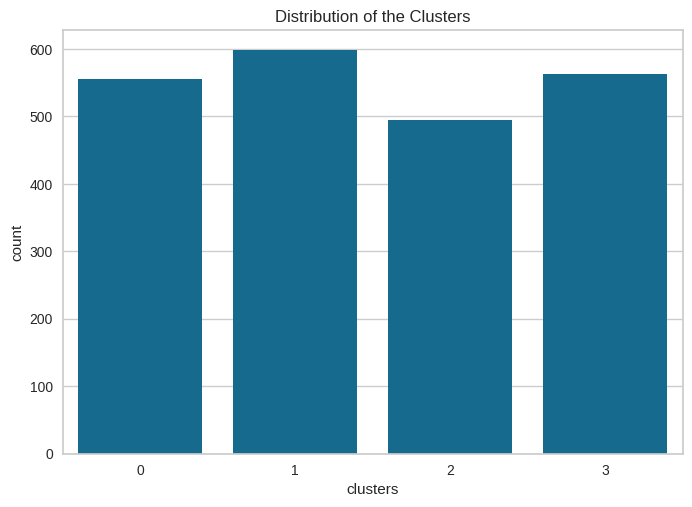

In [71]:
#plotting coutplot of clusters

sns.countplot(x=df['clusters'])
plt.title('Distribution of the Clusters')
plt.show()

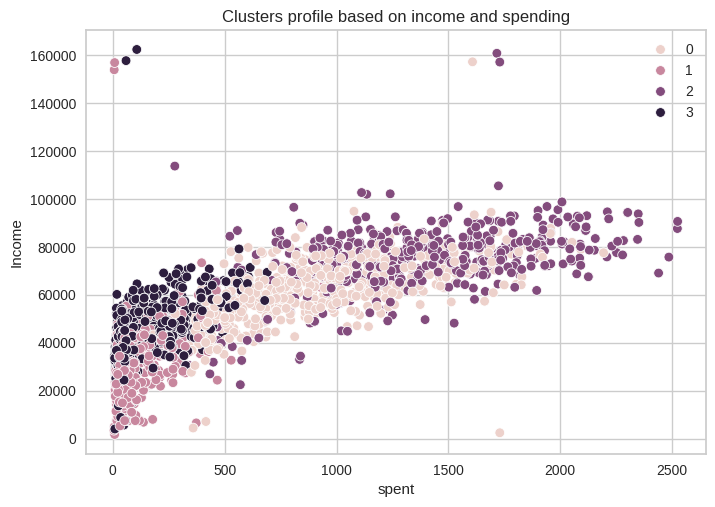

In [72]:
sns.scatterplot(data=df, x='spent', y='Income', hue='clusters')
plt.title('Clusters profile based on income and spending')
plt.legend()
plt.show()

group 0: high spending, average income
group 1: low spending, low income
group 2: high spending, high income
group 3: high spending, low income

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 14.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 71.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 56.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 22.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 74.2% of the points cannot be plac

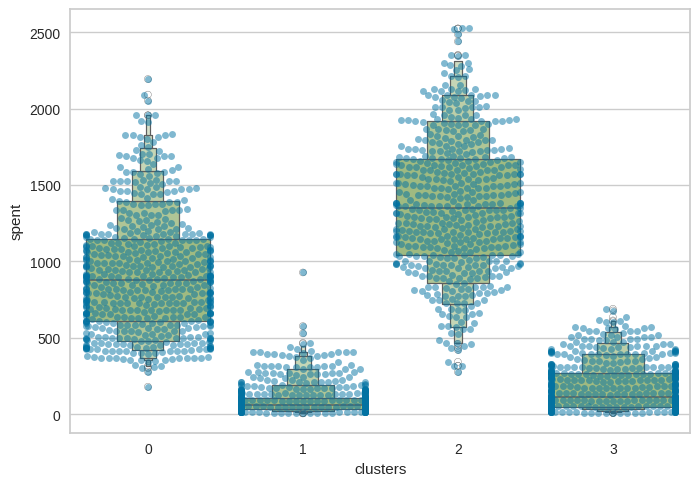

In [77]:
plt.figure()
sns.swarmplot(x=df['clusters'], y=df['spent'], alpha=0.5)
sns.boxenplot(x=df['clusters'], y=df['spent'])
plt.show();

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2212 entries, 0 to 2239
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Income               2212 non-null   float64
 1   Kidhome              2212 non-null   int64  
 2   Teenhome             2212 non-null   int64  
 3   Recency              2212 non-null   int64  
 4   Wines                2212 non-null   int64  
 5   Fruits               2212 non-null   int64  
 6   Meat                 2212 non-null   int64  
 7   Fish                 2212 non-null   int64  
 8   Sweets               2212 non-null   int64  
 9   Gold                 2212 non-null   int64  
 10  NumDealsPurchases    2212 non-null   int64  
 11  NumWebPurchases      2212 non-null   int64  
 12  NumCatalogPurchases  2212 non-null   int64  
 13  NumStorePurchases    2212 non-null   int64  
 14  NumWebVisitsMonth    2212 non-null   int64  
 15  AcceptedCmp3         2212 non-null   int64 

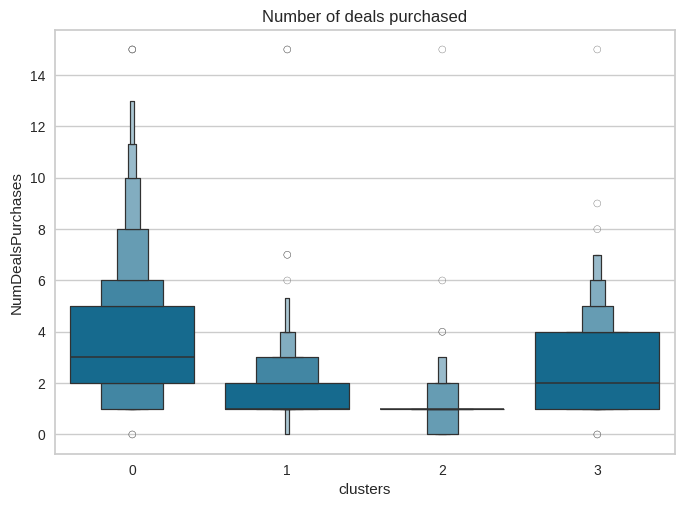

In [81]:
#plotting the number of deals purchased
plt.figure()
sns.boxenplot(y=df['NumDealsPurchases'], x=df['clusters'])
plt.title('Number of deals purchased')
plt.show()

<Figure size 800x550 with 0 Axes>

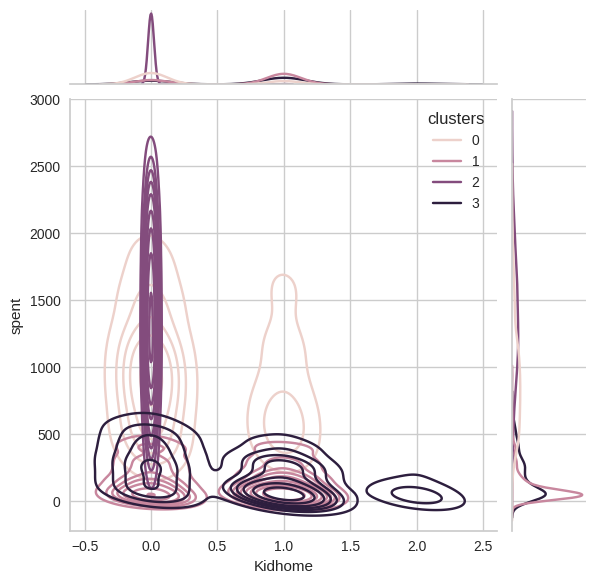

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

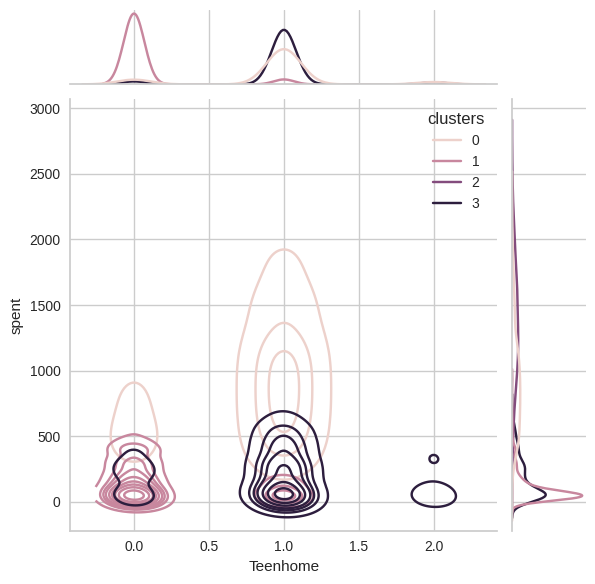

<Figure size 800x550 with 0 Axes>

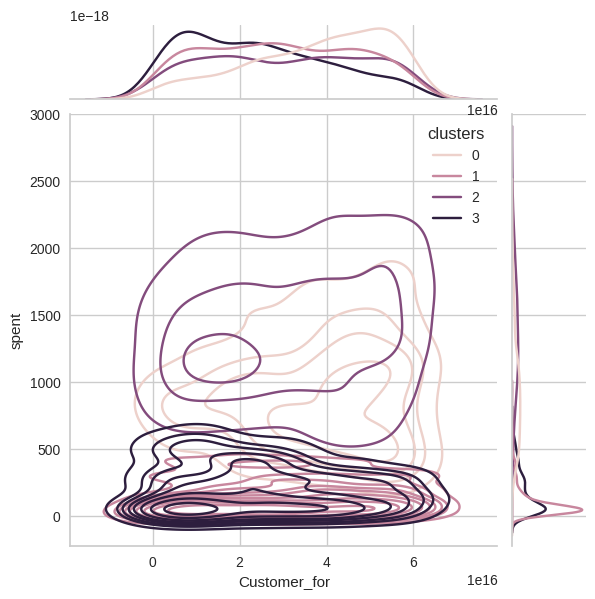

<Figure size 800x550 with 0 Axes>

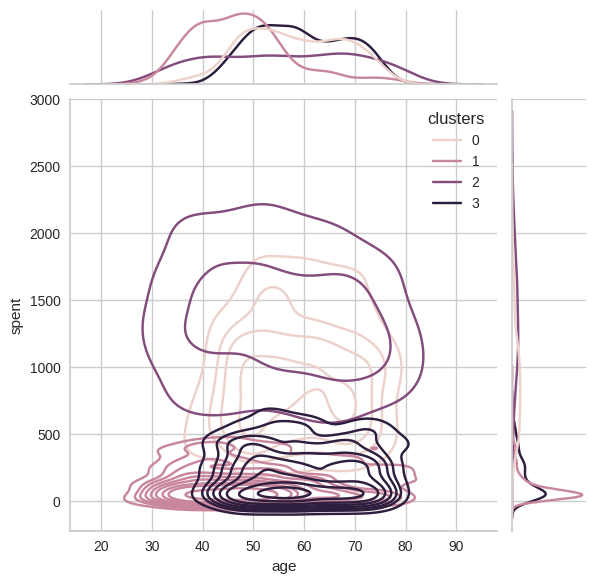

<Figure size 800x550 with 0 Axes>

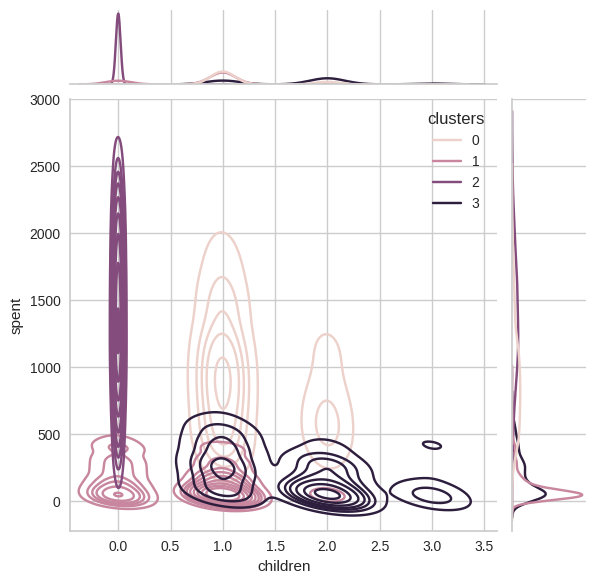

<Figure size 800x550 with 0 Axes>

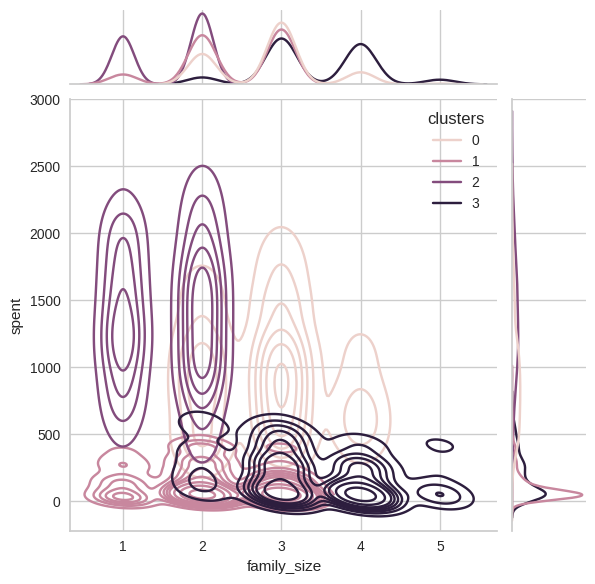

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

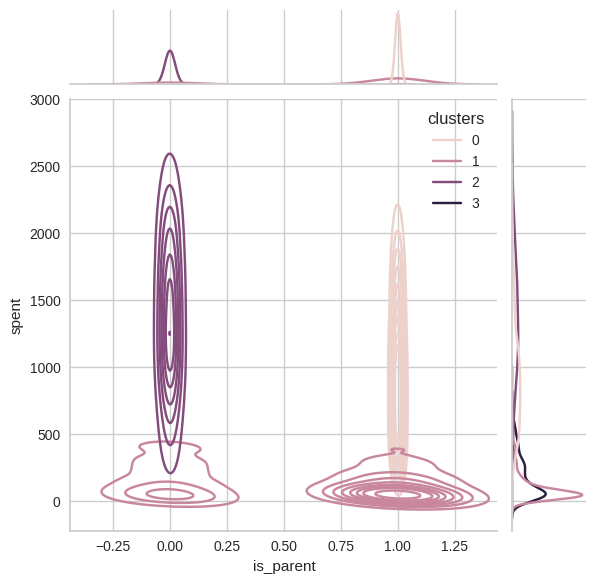

<Figure size 800x550 with 0 Axes>

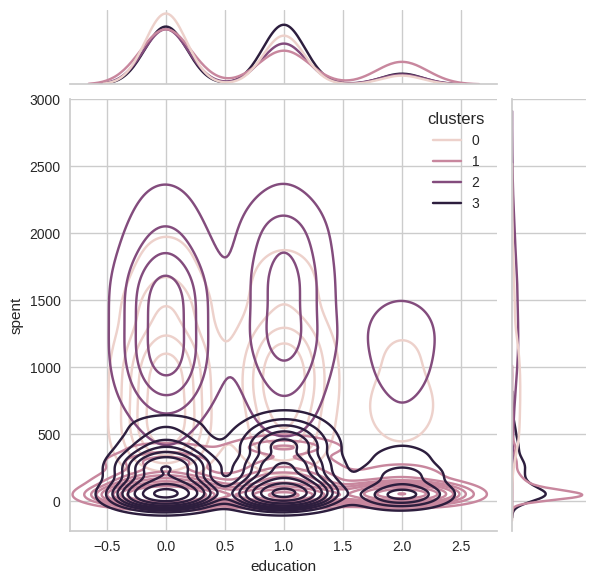

<Figure size 800x550 with 0 Axes>

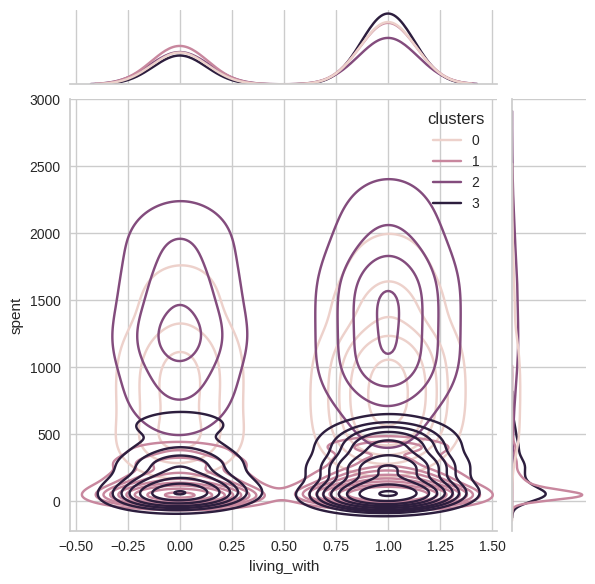

In [86]:
Personal = [ "Kidhome","Teenhome","Customer_for", "age", "children", "family_size", "is_parent", "education","living_with"]
for i in Personal:
  plt.figure()
  sns.jointplot(x=df[i], y=df['spent'], hue=df['clusters'], kind='kde')
  plt.show()

### group 0:
-they have 1 or 2 children
- family size maximum is 4
- majority of them is parent
- relatively older

### gropu 1:
- max family size is 3
- thay 0 or 1 children
- relatively younger
- majority of them dont have teen at home


### group 2:
- they are not a parent
-family size is 0 or 1
- number of childern is mostly 0
- they spent the most money

### group 3:
- spend relativly lower money
- relatively new custometors
- they have at least one child
